## Bagging

In [46]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [4]:
df = sns.load_dataset('titanic')
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [9]:
df.dropna(inplace=True)

In [20]:
# X, yを作成
X = df.loc[:, (df.columns!='survived') & (df.columns!='alive')]
y = df['survived']
# カテゴリ変数の特徴量を整数に変換する
oe = OrdinalEncoder()
# numpyからdfの形に変換
oe.set_output(transform='pandas')
X = oe.fit_transform(X)
# トレーニングデータとテストデータを7:3に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = BaggingClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)

In [27]:
y_pred[:5]

array([[0.5, 0.5],
       [0.8, 0.2],
       [0.1, 0.9],
       [0. , 1. ],
       [0.3, 0.7]])

In [28]:
y_test[:5]

484    1
110    0
195    1
496    1
889    1
Name: survived, dtype: int64

In [32]:
print(f"bagging AUC: {roc_auc_score(y_test, y_pred[:, 1])}")

bagging AUC: 0.8974358974358974


In [39]:
# 単一の決定木の精度
single_tree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
y_pred_tree = single_tree.predict_proba(X_test)
print(f"single tree AUC: {roc_auc_score(y_test, y_pred_tree[:, 1])}")

single tree AUC: 0.7724358974358974


In [38]:
# バギングで作った決定木のリストを確認することが可能
clf.estimators_

[DecisionTreeClassifier(random_state=2087557356),
 DecisionTreeClassifier(random_state=132990059),
 DecisionTreeClassifier(random_state=1109697837),
 DecisionTreeClassifier(random_state=123230084),
 DecisionTreeClassifier(random_state=633163265),
 DecisionTreeClassifier(random_state=998640145),
 DecisionTreeClassifier(random_state=1452413565),
 DecisionTreeClassifier(random_state=2006313316),
 DecisionTreeClassifier(random_state=45050103),
 DecisionTreeClassifier(random_state=395371042)]

# Random Forest

In [42]:
rf = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=0).fit(X_train, y_train)
y_pred_rf = rf.predict_proba(X_test)
print(f"random forest AUC: {roc_auc_score(y_test, y_pred_rf[:, 1])}")

random forest AUC: 0.9447115384615384


In [43]:
rf.feature_importances_

array([0.01, 0.17, 0.12, 0.06, 0.01, 0.06, 0.01, 0.01, 0.22, 0.24, 0.06,
       0.  , 0.03])

<BarContainer object of 13 artists>

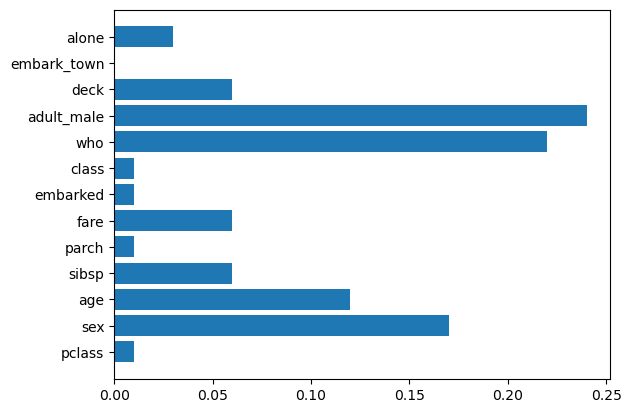

In [45]:
# どの特徴量(カラム）が重要なのか
# 子供や女性が優先的に助けられたか
plt.barh(X.columns, rf.feature_importances_)

[Text(0.5, 0.75, 'x[9] <= 0.5\ngini = 0.453\nsamples = 77\nvalue = [44, 83]'),
 Text(0.25, 0.25, 'gini = 0.195\nsamples = 37\nvalue = [7, 57]'),
 Text(0.75, 0.25, 'gini = 0.485\nsamples = 40\nvalue = [37, 26]')]

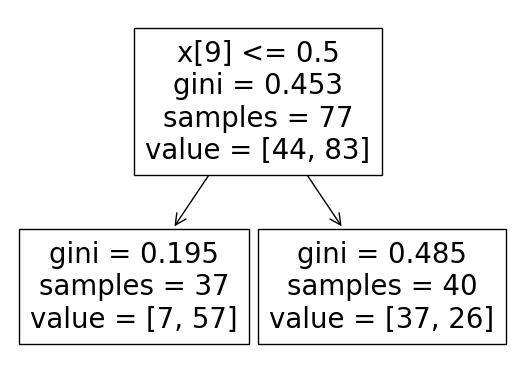

In [51]:
# 決定木描画
plot_tree(rf.estimators_[0])